# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# Example grids

In [3]:
easy_grid = np.loadtxt("../../data/robot_grids/easy_grid.csv", delimiter=",", dtype=int)
medium_grid = np.loadtxt("../../data/robot_grids/medium_grid.csv", delimiter=",", dtype=int)
hard_grid = np.loadtxt("../../data/robot_grids/hard_grid.csv", delimiter=",", dtype=int)

# Game initialization

## Game rule constants

In [4]:
start_field, empty_field, obstacle_field, target_field = 0, 1, 2, 3
max_velocity = 2

## Learning parameters

In [5]:
game_grid = hard_grid
n_episodes = 1000
gamma = 0.9

## Grid visiualization

In [6]:
def plot_grid(grid_state, robot_state=None, policy=None, cmap=ListedColormap(["blue", "grey", "black", "green"]), field_labels=["Start", "Empty", "Obstacle", "Target"]):
    
    plt.figure(figsize=(12, 8))
    plt.imshow(grid_state, cmap=cmap)

    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap.colors[i]) for i in range(len(field_labels))]
    plt.legend(legend_handles, field_labels, loc="upper left", bbox_to_anchor=(1, 1))

    if robot_state is not None:
        i, j = robot_state
        plt.text(j, i, "Robot", color="red", fontsize=14, ha="center", va="center")
        
    if policy is not None:
        for i in range(grid_state.shape[0]):
            for j in range(grid_state.shape[1]):
                if grid_state[i, j] != obstacle_field and grid_state[i, j] != target_field:
                    dx, dy = policy.get((i, j), (0, 0))
                    plt.arrow(j, i, dy * 0.3, dx * 0.3, head_width=0.2, head_length=0.2, fc="white", ec="white")

    plt.grid(False)
    plt.show()

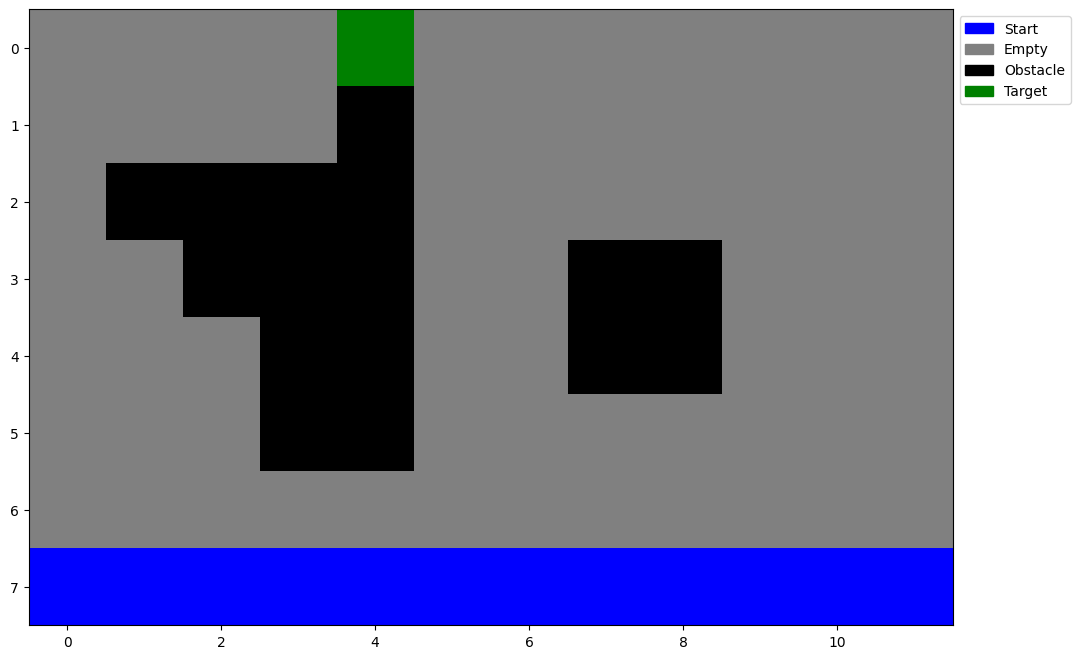

In [7]:
plot_grid(game_grid)

## Agent initialization

- Search for the field set as the target and save it in a variable
- Define the allowed actions based on the max velociy value
- Initialize all potential states (fields within the grid that are no obstacles)
- Initialize all states with some values

In [8]:
target = tuple(np.argwhere(game_grid == target_field)[0])

actions = [(i, j) for i in range(-max_velocity, max_velocity + 1) for j in range(-max_velocity, max_velocity + 1) if (i, j) != (0, 0)]

states = [(i, j) for i in range(len(game_grid)) for j in range(len(game_grid[0])) if game_grid[i, j] != obstacle_field]

state_values = {state: 0 for state in states}
state_visits = {state: 1 for state in states} # simple way to prevent division by zero, could be done differently

# Episode generation function

An episode represents one path of a robot which leads to the target field. This function calculates infinately many random actions put together in a sequence until the sum of all actions are the coordinates of the target field.

Following rules are added to reduce runtime and errors:
- No action can result in the robot leaving the grid
- The robot can not move to an obstacle

In case of the robot having no option to move (crashing into an obstacle because of too high velocity), the robot is put back in the starting position. The sequence continues from there, leading to a high error for the actions in this episode.

In [9]:
def generate_episode(grid, actions, start):
    episode = []

    state = start
    action = [0, 0]
    episode.append((state, action))
    
    while grid[state] != target_field:
        action_options = [
            next_action for next_action in actions 
            if abs(action[0] - next_action[0]) <= 1 # not crossing left border
            and abs(action[1] - next_action[1]) <= 1 # not crossing top border
            and 0 <= state[0] + next_action[0] < grid.shape[0] # not crossing right border
            and 0 <= state[1] + next_action[1] < grid.shape[1] # not crossing bottom border
            and grid[tuple(np.add(state, next_action))] != obstacle_field # no obstacel
        ]
        if (len(action_options) > 0):
            # pick any available action
            action = action_options[np.random.randint(len(action_options))]
            next_state = tuple(np.add(state, action))
        else:
            # start from starting point
            action = [0, 0]
            next_state = start
        
        episode.append((state, action))
        state = next_state

    return episode

# Training

## Generate episodes and determine state values

Using n episodes, the value for the states are determined.
Each action is punished by a penalty of -1.

In [10]:
for _ in range(n_episodes):
    start_options = np.argwhere(game_grid == start_field)
    start = tuple(start_options[np.random.randint(start_options.shape[0])])

    episode = generate_episode(game_grid, actions, start)  

    total_return = 0
    for state, action in reversed(episode):
        total_return = gamma * total_return - 1
        state_values[state] += total_return
        state_visits[state] += 1  

## Setup policy following leading to paths of highest state values

The resulting policy is the action for each state, which moves the robot to a state with the least experienced penalty (least negative state value).

In [11]:
policy = {}
for state in state_values.keys():
    if state != target:
        possible_actions = [a for a in actions if tuple(np.add(state, a)) in states and game_grid[tuple(np.add(state, a))] != obstacle_field]
            
        best_action = max(possible_actions, key=lambda a: state_values.get(tuple(np.add(state, a))) / state_visits.get(tuple(np.add(state, a))))
        policy[state] = best_action

# Visualization of the policy

## Example path following the policy

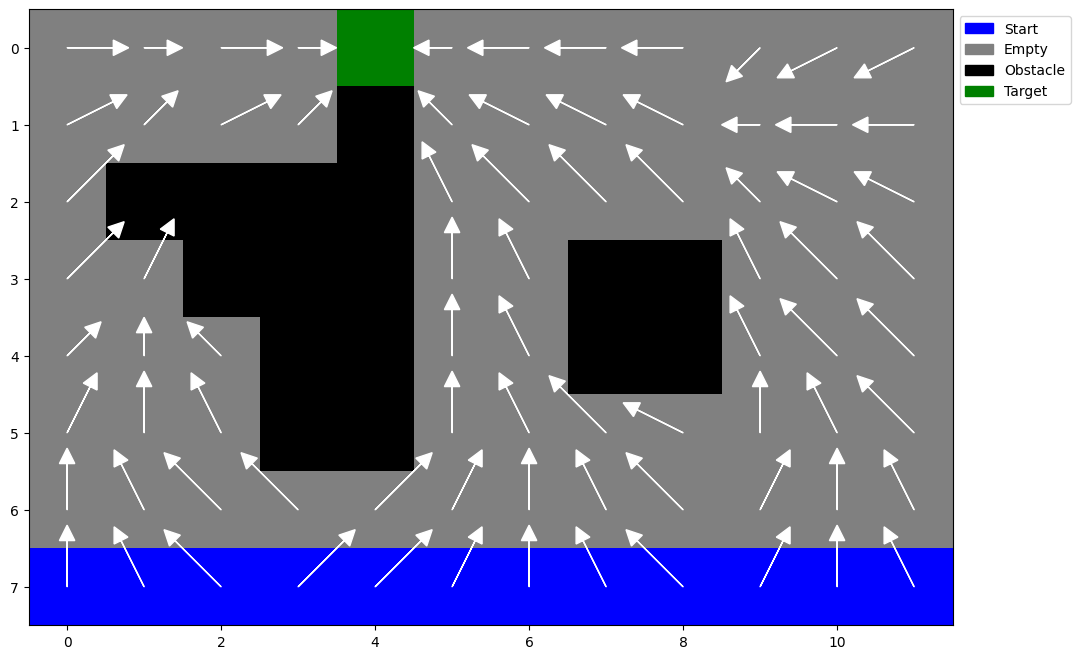

In [17]:
def plot_gride(grid_state, robot_state=None, policy=None, cmap=ListedColormap(["blue", "grey", "black", "green"]), field_labels=["Start", "Empty", "Obstacle", "Target"]):
    plt.figure(figsize=(12, 8))
    plt.imshow(grid_state, cmap=cmap)

    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap.colors[i]) for i in range(len(cmap.colors))]
    for i, handle in enumerate(legend_handles):
        handle.set_label(field_labels[i])

    if robot_state is not None:
        robot_legend = Line2D([0], [0], marker='o', color='w', label='Robot', markersize=10, markerfacecolor='red')
        legend_handles.append(robot_legend)

    plt.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1))

    if policy is not None:
        for i in range(grid_state.shape[0]):
            for j in range(grid_state.shape[1]):
                if grid_state[i, j] != -1 and (i, j) in policy:  # Check if the cell is not an obstacle and has a policy action
                    dx, dy = policy[(i, j)]
                    plt.arrow(j, i, dy * 0.3, dx * 0.3, head_width=0.2, head_length=0.2, fc="white", ec="white")

    plt.grid(False)
    plt.show()

plot_gride(game_grid, policy=policy)

# Paths

Path for simulation 1:


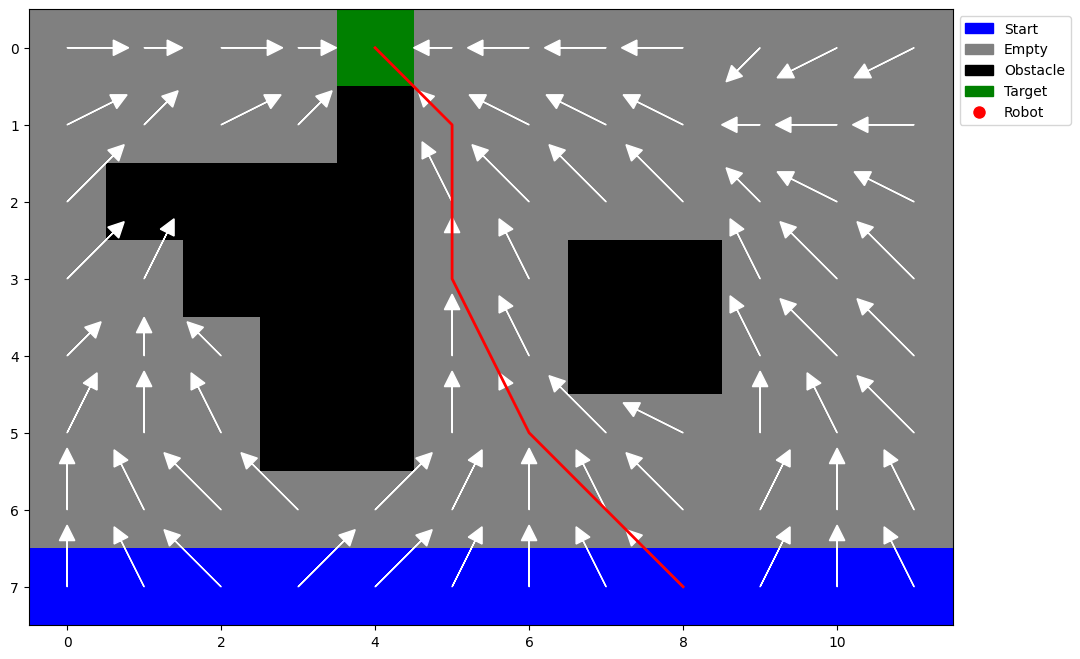

Path for simulation 2:


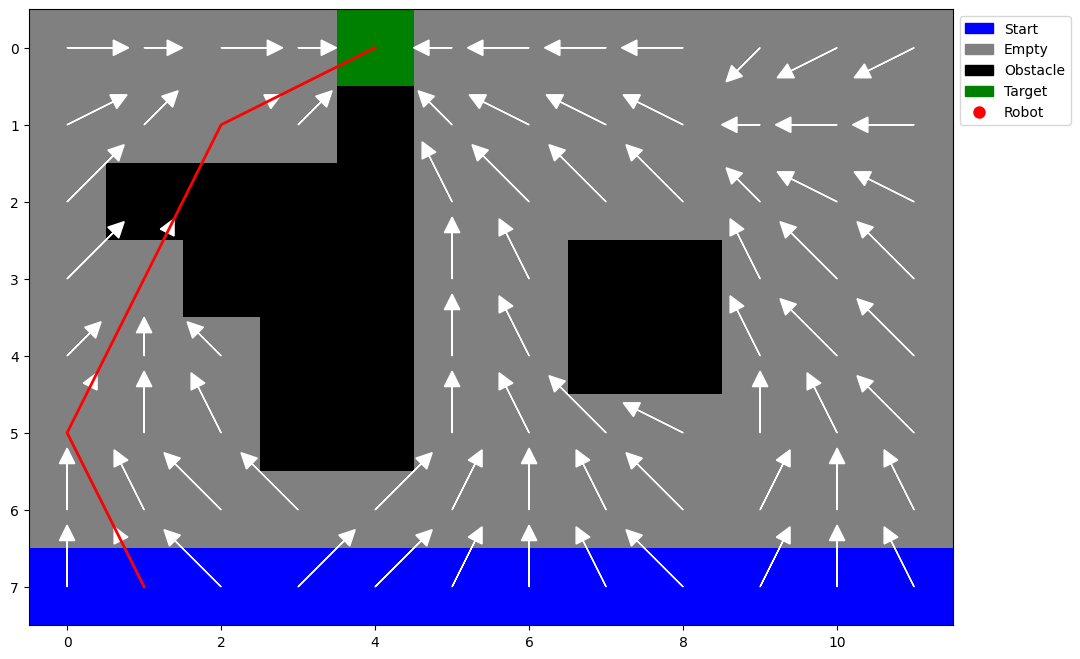

Path for simulation 3:


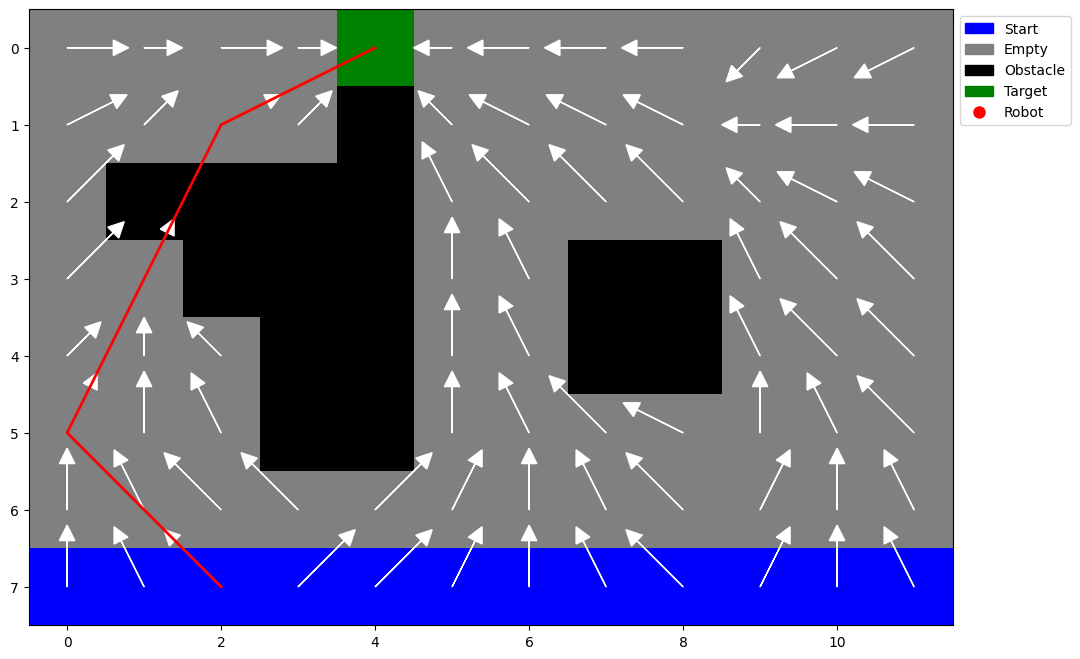

Path for simulation 4:


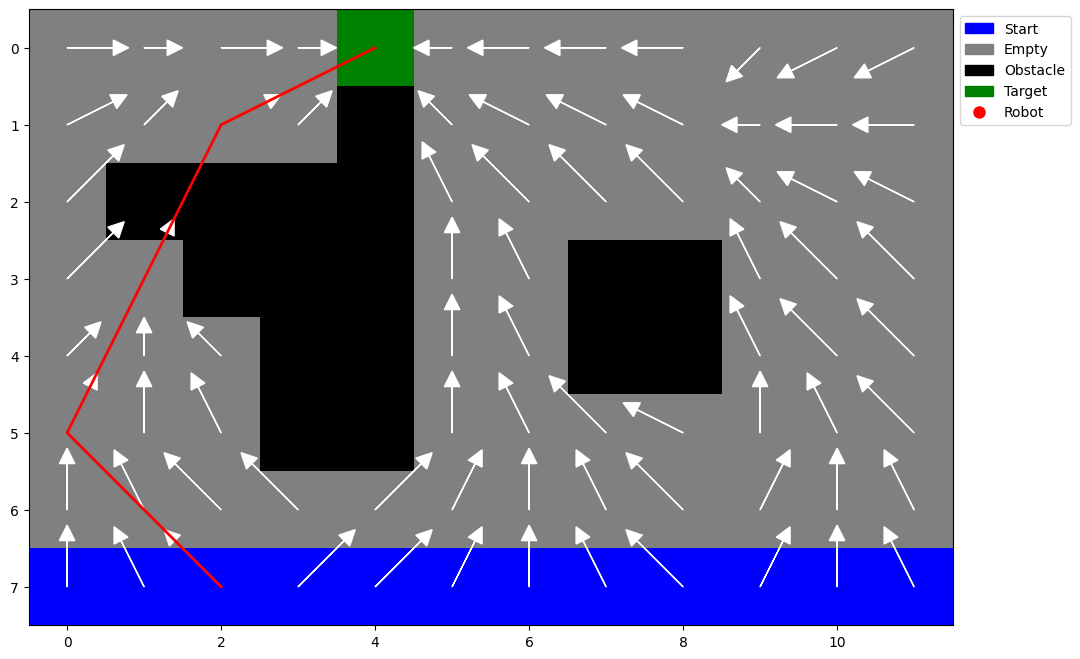

Path for simulation 5:


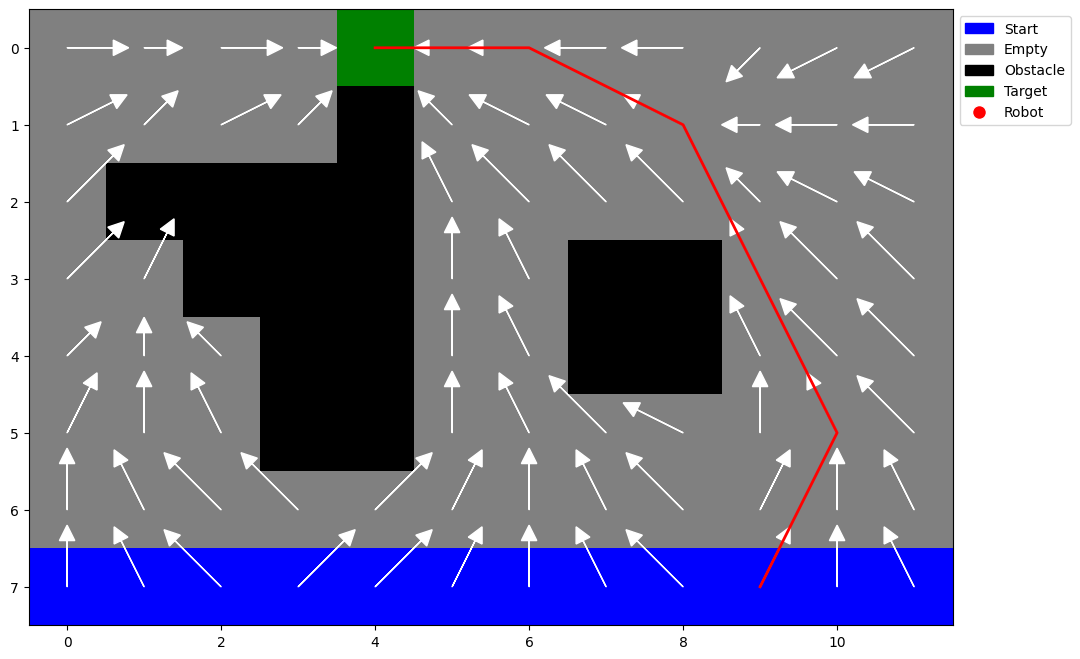

In [18]:
def plot_grid(grid_state, robot_state=None, policy=None, path=None, cmap=ListedColormap(["blue", "grey", "black", "green"]), field_labels=["Start", "Empty", "Obstacle", "Target"]):
    plt.figure(figsize=(12, 8))
    plt.imshow(grid_state, cmap=cmap)

    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap.colors[i]) for i in range(len(cmap.colors))]
    for i, handle in enumerate(legend_handles):
        handle.set_label(field_labels[i])

    if robot_state is not None:
        robot_legend = Line2D([0], [0], marker='o', color='w', label='Robot', markersize=10, markerfacecolor='red')
        legend_handles.append(robot_legend)

    plt.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1))

    if policy is not None:
        for i in range(grid_state.shape[0]):
            for j in range(grid_state.shape[1]):
                if grid_state[i, j] != -1 and (i, j) in policy:  # Check if the cell is not an obstacle and has a policy action
                    dx, dy = policy[(i, j)]
                    plt.arrow(j, i, dy * 0.3, dx * 0.3, head_width=0.2, head_length=0.2, fc="white", ec="white")

    if path is not None:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], color='red', linewidth=2)

    plt.grid(False)
    plt.show()

# Number of simulations
num_simulations = 5

for sim in range(num_simulations):
    start_positions = np.argwhere(game_grid == start_field)
    start_position = tuple(start_positions[np.random.randint(len(start_positions))])

    robot_state = start_position
    path = [robot_state]

    while game_grid[robot_state] != target_field:
        action = policy.get(robot_state)
        if action is not None:
            robot_state = tuple(np.add(robot_state, action))
            path.append(robot_state)
        else:
            print("No valid action, stuck in the grid.")
            break

    print(f"Path for simulation {sim + 1}:")
    plot_grid(game_grid, robot_state, policy, path)